## 5. Find and Download Landsat 8 Remote Sensing Data From the USGS Earth Explorer Website

https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/landsat-in-Python/get-landsat-data-earth-explorer/ 

## 6. Practice Opening and Plotting Landsat Data in Python Using Rasterio

In [45]:
import os
from glob import glob

import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from shapely.geometry import mapping
import numpy as np
import numpy.ma as ma
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import  rasterio as rio

# Download data and set working directory
data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data', 'cold-springs-fire',
                      'landsat_collect', 'LC080340322016070701T1-SC20180214145604', 'crop'))

### Challenge 1: Open And Crop Your Data
Above, you opened up the landsat scene in the directory: LC080340322016072301T1-SC20180214145802. This data covers an area which a file occured near Nederland, Colorado. For this challenge, you will work with data that was collected before the fire for the same area. Do the following:

- 1.Crop all of the bands (tif files with the word “band” in them, in the LC080340322016070701T1-SC20180214145604 directory using xarray concat() and rioxarray rio.clip().
- 2.Make sure your fire boundary data is in the correct crs before clipping the array!
- 3.Plot the data using ep.plot_bands()

In [46]:
os.getcwd() # get current directory

'C:\\Users\\34639\\earth-analytics\\data\\cold-springs-fire\\landsat_collect\\LC080340322016070701T1-SC20180214145604\\crop'

In [47]:
landsat_pre_fire_path = os.path.join(os.getcwd()) # path is the current dir
glob(os.path.join(landsat_pre_fire_path, "*"))

['C:\\Users\\34639\\earth-analytics\\data\\cold-springs-fire\\landsat_collect\\LC080340322016070701T1-SC20180214145604\\crop\\LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif',
 'C:\\Users\\34639\\earth-analytics\\data\\cold-springs-fire\\landsat_collect\\LC080340322016070701T1-SC20180214145604\\crop\\LC08_L1TP_034032_20160707_20170221_01_T1_radsat_qa_crop.tif',
 'C:\\Users\\34639\\earth-analytics\\data\\cold-springs-fire\\landsat_collect\\LC080340322016070701T1-SC20180214145604\\crop\\LC08_L1TP_034032_20160707_20170221_01_T1_sr_aerosol_crop.tif',
 'C:\\Users\\34639\\earth-analytics\\data\\cold-springs-fire\\landsat_collect\\LC080340322016070701T1-SC20180214145604\\crop\\LC08_L1TP_034032_20160707_20170221_01_T1_sr_band1_crop.tif',
 'C:\\Users\\34639\\earth-analytics\\data\\cold-springs-fire\\landsat_collect\\LC080340322016070701T1-SC20180214145604\\crop\\LC08_L1TP_034032_20160707_20170221_01_T1_sr_band2_crop.tif',
 'C:\\Users\\34639\\earth-analytics\\data\\cold-springs-fire\\

In [81]:
# Only grab bands 2 through 5
all_landsat_pre_bands = glob(os.path.join(landsat_post_fire_path,
                                           "*band*.tif")) # 2 and 5 included
all_landsat_pre_bands

['C:\\Users\\34639\\earth-analytics\\data\\cold-springs-fire\\landsat_collect\\LC080340322016070701T1-SC20180214145604\\crop\\LC08_L1TP_034032_20160707_20170221_01_T1_sr_band1_crop.tif',
 'C:\\Users\\34639\\earth-analytics\\data\\cold-springs-fire\\landsat_collect\\LC080340322016070701T1-SC20180214145604\\crop\\LC08_L1TP_034032_20160707_20170221_01_T1_sr_band2_crop.tif',
 'C:\\Users\\34639\\earth-analytics\\data\\cold-springs-fire\\landsat_collect\\LC080340322016070701T1-SC20180214145604\\crop\\LC08_L1TP_034032_20160707_20170221_01_T1_sr_band3_crop.tif',
 'C:\\Users\\34639\\earth-analytics\\data\\cold-springs-fire\\landsat_collect\\LC080340322016070701T1-SC20180214145604\\crop\\LC08_L1TP_034032_20160707_20170221_01_T1_sr_band4_crop.tif',
 'C:\\Users\\34639\\earth-analytics\\data\\cold-springs-fire\\landsat_collect\\LC080340322016070701T1-SC20180214145604\\crop\\LC08_L1TP_034032_20160707_20170221_01_T1_sr_band5_crop.tif',
 'C:\\Users\\34639\\earth-analytics\\data\\cold-springs-fire\\lan

## Functions

In [82]:
def check_crs(raster_path):
    """
    Returns the CRS of a raster file.

    Parameters
    ----------
    raster_path : string
        A path to a raster file that you wish to check the crs of. Assuming
        this is a tif file.

    Returns
    -------
    A crs object

    """

    with rio.open(all_landsat_post_bands[0]) as src:
        return src.crs

In [99]:
def open_clean_band(band_path, clip_extent, valid_range=None):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.

    clip_extent : geopandas geodataframe
        A geodataframe containing the clip extent of interest. NOTE: this will 
        fail if the clip extent is in a different CRS than the raster data.

    valid_range : tuple (optional)
        The min and max valid range for the data. All pixels with values outside
        of this range will be masked.

    Returns
    -------
    An single xarray object with the Landsat band data.

    """

    try:
        clip_bound = clip_extent.geometry
    except Exception as err:
        print("Oops, I need a geodataframe object for this to work.")
        print(err)

    cleaned_band = rxr.open_rasterio(band_path,
                                     masked=True).rio.clip(clip_bound,
                                                           from_disk=True).squeeze()

    # Only mask the data if a valid range tuple is provided
    if valid_range:
        mask = ((landsat_post_xr_clip < valid_range[0]) | (
            landsat_post_xr_clip > valid_range[1]))
        cleaned_band = landsat_post_xr_clip.where(
            ~xr.where(mask, True, False))

    return cleaned_band

In [110]:
def process_bands(paths, crop_layer, stack=False):
    """
    Open, clean and crop a list of raster files using rioxarray.

    Parameters
    ----------
    paths : list
        A list of paths to raster files that could be stacked (of the same 
        resolution, crs and spatial extent).
    
    crop_layer : geodataframe
        A geodataframe containing the crop geometry that you wish to crop your
        data to.
        
    stack : boolean
        If True, return a stacked xarray object. If false will return a list
        of xarray objects.

    Returns
    -------
        Either a list of xarray objects or a stacked xarray object
    """

    all_bands = []
    for i, aband in enumerate(paths):
        cleaned = open_clean_band(aband, crop_layer)
        cleaned["band"] = i+1
        all_bands.append(cleaned)

    if stack:
        print("I'm stacking your data now.")
        return xr.concat(all_bands, dim="band")
    else:
        print("Returning a list of xarray objects.")
        return all_bands
        

## AOI

In [100]:
# Open up boundary extent using GeoPandas
fire_boundary_path = "C:/Users/34639/earth-analytics/data/cold-springs-fire/vector_layers/fire-boundary-geomac/co_cold_springs_20160711_2200_dd83.shp"

fire_boundary = gpd.read_file(fire_boundary_path)

In [101]:
# Check the CRS of your data
with rio.open(all_landsat_pre_bands[0]) as src:
    landsat_crs = src.crs

print("Landsat crs is:", landsat_crs)
print("Fire boundary crs", fire_boundary.crs)

Landsat crs is: EPSG:32613
Fire boundary crs epsg:4269


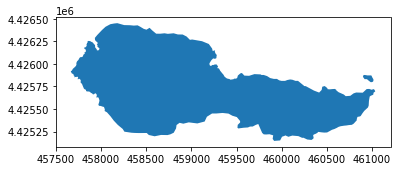

In [102]:
# Reproject data to CRS of raster data
fire_boundary_utmz13 = fire_boundary.to_crs(landsat_crs)
fire_boundary_utmz13.plot()
plt.show()

In [117]:
# Process all bands
pre_fire_stack = process_bands(all_landsat_pre_bands, 
                                fire_boundary_utmz13, 
                                stack=True)
post_fire_stack.shape

I'm stacking your data now.


(7, 44, 113)

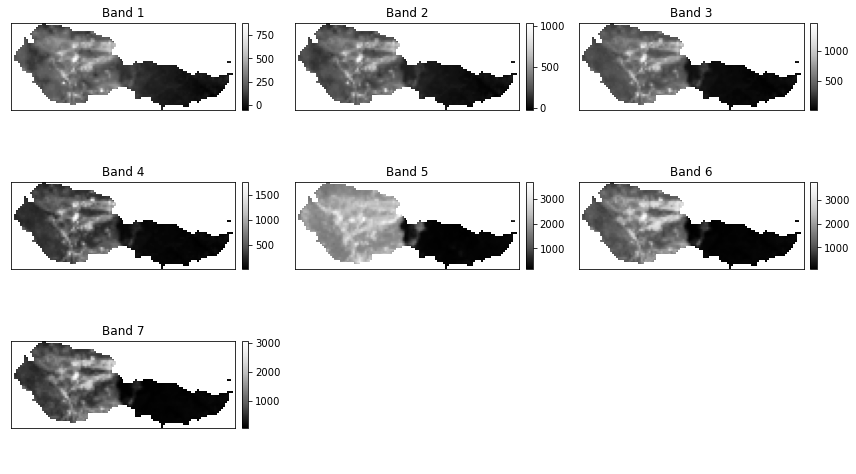

<Figure size 432x288 with 0 Axes>

In [118]:
# Plot using earthpy
# Plot the final data
ep.plot_bands(pre_fire_stack,
             cols=3,
             figsize=(12,7))
plt.suptitle("Cleaned and Cropped Landsat Bands pre-fire")
plt.show()

## Challenge 2 (Optional): Plot CIR and RGB Images Using Landsat
In this lesson which introduces working with Landsat data in open source Python, you learn how to plot both a color RGB and Color Infrared (CIR) images using landsat data. Create a figure below that has:

- 1.A color RGB image of the landsat data collected post fire
- 2.A CIR image of the landsat data collected post fire.

HINT: You will need to set the correct band combinations for your plots to turn our properly. You will also have to mask out the nan values for your plot to work.

- For Regular color images use: rgb=[3, 2, 1]
- For color infrared use: rgb=[4, 3, 2]

Hint: If you want to plot your data as a color composit RGB map, you can use earthpy’s plot_rgb() function. For this to work, you will need to:

- Mask nan values from your data - these are the values that you cleaned above.
- Apply the mask to your xarray object using ma.masked_array.

You can create a mask of where nan values are with np.isnan(array_name), and apply it with ma.masked_array(original_array, numpy_mask).

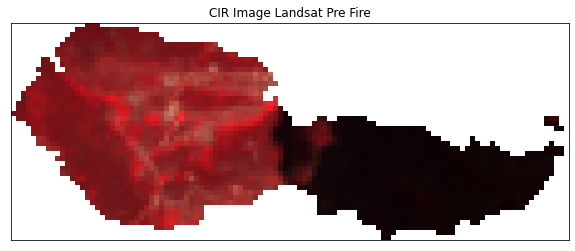

In [123]:
# Create nan mask
mask_nan = np.isnan(pre_fire_stack)

# Apply nan mask to cropped data - this turns your data into a numpy array
landsat_pre_arr_masked = ma.masked_array(pre_fire_stack,
                                          mask=mask_nan)

# Plot masked array
ep.plot_rgb(landsat_pre_arr_masked,
            rgb=[4, 3, 2],
            title="CIR Image Landsat Pre Fire")

plt.show()

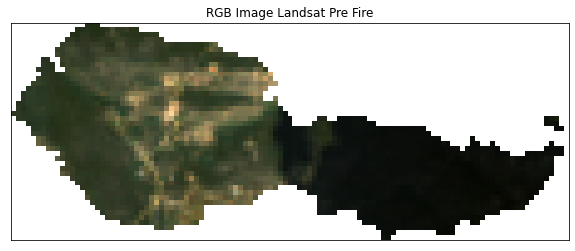

In [124]:

# Plot masked array
ep.plot_rgb(landsat_pre_arr_masked,
            rgb=[3, 2, 1],
            title="RGB Image Landsat Pre Fire")

plt.show()